In [1]:
cd ..

e:\deep learning python\facial_keypoint-training


C:\Users\dell\AppData\Roaming\Python\Python311\site-packages\IPython\core\magics\osm.py:417: UserWarning: This is now an optional IPython functionality, setting dhist requires you to install the `pickleshare` library.
  self.shell.db['dhist'] = compress_dhist(dhist)[-100:]


Import packages

In [8]:
#inbuilt packages
import os
from PIL import Image

#DataScience packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

#Pytorch related packages
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from torchvision import models

Hyper Parameters

In [3]:
batch_size = 16
model_input_size = 224
n_epoch = 10
learning_rate = 0.001

In [4]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cpu')

Data Loader

In [5]:
class FaceKeyPointData(Dataset):
    def __init__(self, csv_path='data/training_frames_keypoints.csv', split='training', device=torch.device('cpu')):
        super(FaceKeyPointData, self).__init__()
        self.csv_path = csv_path
        self.split = split
        self.df = pd.read_csv(self.csv_path)
        self.device = torch.device(device)
        #print(self.df)
        #self.model_input_size = model_input_size  # Define model_input_size
        self.normalize = transforms.Normalize(
            mean=[0.458, 0.456, 0.406],
            std=[0.229, 0.224, 0.225]
        )

    def __len__(self):
        return len(self.df)

    def __getitem__(self, index):
        img, original_size = self.get_img(index)
        key_points = self.get_keypoints(index=index, original_size=original_size)
        return img, key_points
    
    def get_img(self, index):
        # print(os.getcwd())
        # print(self.df.iloc[index,0])
        #os.path.join(, ,)
        img_path = os.path.join(os.getcwd(), 'data', self.split, self.df.iloc[index,0])
        img = Image.open(img_path).convert('RGB')
        original_size = img.size
        # print(original_size)

        ##preprocess image
        img = img.resize((model_input_size, model_input_size))
        # print(np.asarray(img)/255.0)
        img = np.asarray(img)/255.0
        # print(img.shape) #img tensor represent as batchsize,channel,width,height but here width,height,channel
        img = torch.tensor(img).permute(2, 0, 1)
        #print(img .shape)
        img = self.normalize(img)
        #print(img)
        return img.to(self.device), original_size
    
    def get_keypoints(self, index, original_size):
        # print(self.df.iloc[index, 1:].tolist())
        kp = self.df.iloc[index, 1:].tolist()
        # kp = self.df.iloc[index, 1:].to_numpy().astype(np.float32) #kpx and kpy no need to convert in array then
        # print(kp)
        # kp_x = (np.array(kp[0::2])/original_size[0]).tolist()
        # kp_y = (np.array(kp[1::2])/original_size[1]).tolist()
        # kp = kp_x + kp_y
        kp_x = (np.array(kp[0::2])/original_size[0])
        kp_y = (np.array(kp[1::2])/original_size[1])
        kp = np.concatenate([kp_x, kp_y])

        # print(kp)
        # print(kp_x)
        # print(kp_y)
        # print(len(kp))
        return torch.tensor(kp).to(self.device)
    
    def load_img(self, index):
        img_path = os.path.join(os.getcwd(), 'data', self.split, self.df.iloc[index,0])
        img = Image.open(img_path).convert('RGB')
        img = img.resize((model_input_size, model_input_size))
        return np.asarray(img)/255.0


    
training_data = FaceKeyPointData(device=device)
#training_data[0]
# len(training_data)
test_data = FaceKeyPointData(csv_path='data/test_frames_keypoints', )

(tensor([[[-2.0000, -2.0000, -2.0000,  ..., -2.0000, -2.0000, -2.0000],
          [-2.0000, -2.0000, -2.0000,  ..., -2.0000, -2.0000, -2.0000],
          [-2.0000, -2.0000, -2.0000,  ..., -2.0000, -2.0000, -2.0000],
          ...,
          [-0.3560, -0.3218, -0.3389,  ..., -0.0135, -0.0135, -0.0307],
          [-0.3560, -0.3218, -0.2875,  ..., -0.0135, -0.0135, -0.0307],
          [-0.3389, -0.2875, -0.2533,  ...,  0.0036,  0.0036, -0.0135]],
 
         [[-2.0182, -2.0182, -2.0182,  ..., -2.0182, -2.0182, -2.0182],
          [-2.0182, -2.0182, -2.0182,  ..., -2.0182, -2.0182, -2.0182],
          [-2.0182, -2.0182, -2.0182,  ..., -2.0182, -2.0182, -2.0182],
          ...,
          [-0.2850, -0.2500, -0.2675,  ..., -0.0049, -0.0049, -0.0224],
          [-0.2850, -0.2500, -0.2150,  ..., -0.0049, -0.0049, -0.0224],
          [-0.2675, -0.2150, -0.1800,  ...,  0.0126,  0.0126, -0.0049]],
 
         [[-1.8044, -1.8044, -1.8044,  ..., -1.8044, -1.8044, -1.8044],
          [-1.8044, -1.8044,

In [6]:
training_data.load_img(0)

array([[[0.        , 0.00392157, 0.        ],
        [0.        , 0.00392157, 0.        ],
        [0.        , 0.00392157, 0.        ],
        ...,
        [0.        , 0.00392157, 0.        ],
        [0.        , 0.00392157, 0.        ],
        [0.        , 0.00392157, 0.        ]],

       [[0.        , 0.00392157, 0.        ],
        [0.        , 0.00392157, 0.        ],
        [0.        , 0.00392157, 0.        ],
        ...,
        [0.        , 0.00392157, 0.        ],
        [0.        , 0.00392157, 0.        ],
        [0.        , 0.00392157, 0.        ]],

       [[0.        , 0.00392157, 0.        ],
        [0.        , 0.00392157, 0.        ],
        [0.        , 0.00392157, 0.        ],
        ...,
        [0.        , 0.00392157, 0.        ],
        [0.        , 0.00392157, 0.        ],
        [0.        , 0.00392157, 0.        ]],

       ...,

       [[0.37647059, 0.39215686, 0.3372549 ],
        [0.38431373, 0.4       , 0.34509804],
        [0.38039216, 0

C:\Users\dell\AppData\Local\Temp\ipykernel_51040\45430460.py:14: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  plt.scatter(kp_s[:68]*model_input_size, kp_s[68:]*model_input_size, c='r',s=6, alpha=0.6, edgecolors='black', cmap='viridis')


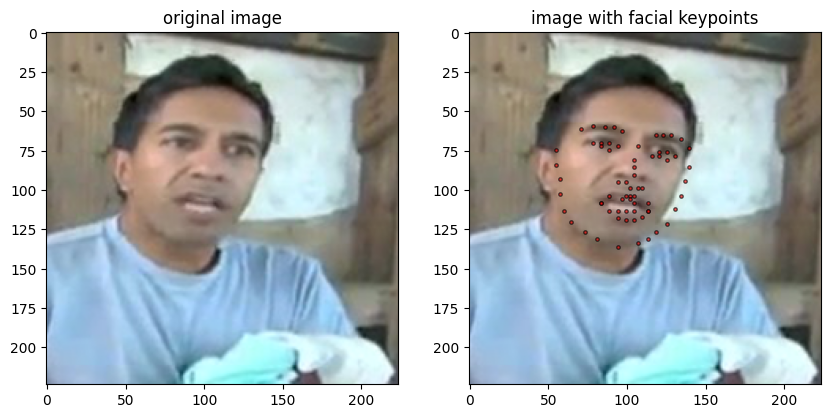

In [7]:
img_index = 20
img = training_data.load_img(20)
plt.figure(figsize=(10,10))
plt.subplot(121)
plt.title('original image')

plt.imshow(img)

plt.subplot(122)
plt.title('image with facial keypoints')
plt.imshow(img)

img_tensor, kp_s = training_data[img_index]
plt.scatter(kp_s[:68]*model_input_size, kp_s[68:]*model_input_size, c='r',s=6, alpha=0.6, edgecolors='black', cmap='viridis')



Model building

In [11]:
def get_model(): 
  model = models.vgg16(weights=models.VGG16_Weights.IMAGENET1K_V1)
  # print(vgg16)
  for layers in model.parameters():
    layers.requires_grad = False

  model.avgpool = nn.Sequential(
    nn.Conv2d[512, 512, 3],
    nn.MaxPool2d(2),
    nn.Flatten()
  )
  model.classifier=nn.Sequential(
    nn.Linear[1000, 512],
    nn.Relu(inplace=True),
    nn.Dropout(0.5),
    nn.Linear(512, 136),
    nn.Sigmoid()
  )
  return model.to(device=device)

model = get_model(device=device)


VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [ ]:
loss=nn.L1Loss
optimizer= torch.optim.adam(model.parameters(), lr=learning_rate)

In [ ]:
def train_batch(imgs, kps, model, criterion, optimizer):
  model.train()
  optimizer.zero_grad()

  #forward pass
  kps_pred=model(imgs)
  loss=criterion(kps_pred, kps)

  #backward pass
  loss.backward()
  optimizer.step()

  return loss


In [ ]:
@torch.no_grad()
def validation_batch(imgs, kps, model, criterion):
  

Training pipeline

In [ ]:
train_loss=[]
test_loss=[]

for epoch in range(1, n_epoch+1):
  epoch_train_loss, epoch_test_loss=0,0

  #train
  for images, kps in train_dataloader:
    #images, kps
    loss=train_batch(images, kps, model, criterion, optimizer)
    epoch_train_loss /= len(train_dataloader)
  